# Modules

In [550]:
import numpy as np
import torch
from torch import nn 
from torch import tensor
from torch.autograd import grad
from datetime import datetime
from numpy.linalg import inv
from scipy.integrate import trapezoid as integrate
from numpy import diff
import matplotlib.pyplot as plt

In [551]:
w = tensor([[2]], requires_grad=True)
a = w
y = tensor([[6]])
out = a * tensor([[1]])


tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000], dtype=torch.float64, requires_grad=True)

# Classes

## Mesh nodes' neural network class

In [552]:
class Node_Shape_Function_Net(nn.Module):
    def __init__(self, x_previous, x_current, x_later, u_i): 
        super().__init__()
        self.x_current = tensor([[x_current]], dtype=torch.float64)
        self.__u = tensor([[u_i]], dtype=torch.float64)
        self.x_later = tensor([[x_later]], dtype=torch.float64) if x_later!=None else None
        self.x_previous = tensor([[x_previous]], dtype=torch.float64) if x_previous!=None else None
        
        # 1. Constructing the layers of the shape function (the ascent and descent parts)
        if x_later!=None: # its not the last node
            # self.x_later.requires_grad = True
            
            descending_layer1 = nn.Linear(1,1)
            descending_layer1.weight = nn.Parameter(tensor([[1.]], dtype=torch.float64)) # w_12_12\n",
            descending_layer1.bias = nn.Parameter(-self.x_current) # b_2_2\n",
            descending_layer1.requires_grad_(False)
            
            descending_layer2 = nn.Linear(1,1).requires_grad_(False)
            descending_layer2.weight = nn.Parameter( -1 / (self.x_later - self.x_current) ) # w_23_22
            descending_layer2.bias = nn.Parameter(tensor([[1.]], dtype=torch.float64)) # b_3_2
            
            descending_layer2 = nn.Linear(1,1)
            descending_layer2.weight = nn.Parameter( -1 / (self.x_later - self.x_current) ) # w_23_22\n",
            descending_layer2.bias = nn.Parameter(tensor([[1.]], dtype=torch.float64)) # b_3_2\n",
            descending_layer2.requires_grad_(False)
            
            descending_layer3 = nn.Linear(1,1)
            descending_layer3.weight = nn.Parameter(tensor([[1.]], dtype=torch.float64)) # w_34_22\n",
            if x_previous!=None:
                descending_layer3.bias = nn.Parameter(tensor([[-0.5]], dtype=torch.float64)) # b_4_2\n",
            elif x_previous==None: # its the first node\n",
                descending_layer3.bias = nn.Parameter(tensor([[0.]], dtype=torch.float64))
            descending_layer3.requires_grad_(False)
            
        if x_previous!=None: # its not the first node
            # self.x_previous.requires_grad = True
            
            ascending_layer1 = nn.Linear(1, 1)
            ascending_layer1.weight = nn.Parameter(tensor([[-1.]], dtype=torch.float64)) # w_12_11
            ascending_layer1.bias = nn.Parameter(self.x_current) # b_2_1
            ascending_layer1.requires_grad_(False)
            
            ascending_layer2 = nn.Linear(1,1)
            ascending_layer2.weight = nn.Parameter( -1 / (self.x_current - self.x_previous)) # w_23_11
            ascending_layer2.bias = nn.Parameter(tensor([[1.]], dtype=torch.float64)) # b_3_1
            ascending_layer2.requires_grad_(False)
            
            ascending_layer3 = nn.Linear(1,1)
            ascending_layer3.weight =  nn.Parameter(tensor([[1.]], dtype=torch.float64)) # w_34_11
            if x_later!=None:
                ascending_layer3.bias = nn.Parameter(tensor([[-0.5]], dtype=torch.float64)) # b_4_1
            elif x_later==None: # its the last node
                ascending_layer3.bias = nn.Parameter(tensor([[0.]], dtype=torch.float64))
            ascending_layer3.requires_grad_(False)

        # 2. Constructing the output layer (displacement)
        w_45_11 = self.__u
        w_45_21 = self.__u
        self.output_layer = nn.Linear(2,1, bias=False)
        self.output_layer.weight = nn.Parameter(torch.cat([w_45_11, w_45_21], 1))
        self.output_layer.requires_grad_(False)
        
        # 3. Assembling the ascent and descent layers
        if x_previous!=None:   
            self.ascendingLayers = nn.Sequential(
                ascending_layer1,
                nn.ReLU(),
                ascending_layer2,
                nn.ReLU(),
                ascending_layer3
            )
        else:
            self.ascendingLayers = -1
            
        if x_later!=None:
            self.descendingLayers = nn.Sequential(
                descending_layer1,
                nn.ReLU(),
                descending_layer2,
                nn.ReLU(),
                descending_layer3
            )
        else:
            self.descendingLayers = -1
    
    @property
    def u(self):
        return self.__u
    
    @u.setter
    def u(self, u_i):
        self.__u = tensor([[u_i]], dtype=torch.float64)
        w_45_11 = self.__u
        w_45_21 = self.__u
        self.output_layer = nn.Linear(2,1, bias=False)
        self.output_layer.weight = nn.Parameter(torch.cat([w_45_11, w_45_21], 1))
        self.output_layer.requires_grad_(False)
    
    def forward(self, dom):
        dom = tensor(np.array([dom]), dtype=torch.float64).reshape((-1,1))
        if self.ascendingLayers == -1:
            out_ascending = torch.zeros_like(dom)
        else:
            out_ascending = self.ascendingLayers(dom)
        
        if self.descendingLayers == -1:
            out_descending = torch.zeros_like(dom)
        else:
            out_descending = self.descendingLayers(dom)
        out = self.output_layer(torch.cat([out_ascending, out_descending], 1))
        return out
        
        

## Main class (assembles the nodes' neural networks)

In [554]:
class HiDeNN_for_FEM():
    def __init__(self, dom, num_nodes, equation, boundary_conditions=[0,0], optimizer=torch.optim.SGD):
        '''
        dom: 
        '''
        self.num_nodes = num_nodes
        self.dom = dom
        self.dom_end = dom[-1]
        self.dom_start = dom[0]
        self.__nodes = tensor(np.linspace(self.dom_start, self.dom_end, num_nodes), requires_grad=True)
        self.u_1 = boundary_conditions[0]
        self.u_n = boundary_conditions[1]
        self.dx = (self.dom_end-self.dom_start)/len(dom)
        self.num_elem = self.num_nodes - 1
        
        # -ku'' + cu' + bu = f
        self.k = equation[0]
        self.c = equation[1]
        self.b = equation[2]
        self.f_func = lambda x_v: list(map(equation[3], x_v))
        
        self.__node_nets_arr = self.node_nets_func( u_arr=[1 for i in range(num_nodes)] )
        self.shape_func_arr = [func_net.forward(dom) for func_net in self.__node_nets_arr]
        self.shape_func_arr = torch.stack(self.shape_func_arr).detach().numpy().reshape(num_nodes, -1)
        
        #### Calculating initial F and K for initial u's #### 
        
        self.__F = [integrate(shape*self.f_func(dom), dx=self.dx) for shape in self.shape_func_arr[1:-1]]
        self.__K = np.zeros((num_nodes, num_nodes))
        for i,func_i in enumerate(self.shape_func_arr):
            for j,func_j in enumerate(self.shape_func_arr):
                df_i = diff(func_i)/self.dx
                df_j = diff(func_j)/self.dx
                integrand = self.k * ( df_i * df_j ) + self.c * ( df_i * func_j[1:] ) + self.b * ( func_i[1:] * func_j[1:] )
                self.__K[i, j] = integrate(integrand, dx=self.dx).reshape(-1)

        # Using the approach of strong condition (big number) - Computationally gives the same result as the theoretically correct way
        # https://scicomp.stackexchange.com/questions/20515/how-to-efficiently-implement-dirichlet-boundary-conditions-in-global-sparse-fini
        BigNumber = 10e64
        self.__F = np.append( BigNumber * self.u_1 , self.__F )
        self.__F = np.append( self.__F, BigNumber * self.u_n )
        self.__K[0,0] = BigNumber
        self.__K[-1,-1] = BigNumber
        
        ### Calculating initial displacements and aprox u ### 
        self.displacement_arr = np.array(inv(self.__K) @ self.__F) # alpha = K^-1 x F
        self.u_aprox_arr = self.displacement_arr @ self.shape_func_arr
            
        for i,node in enumerate(self.__node_nets_arr):
            node.u = self.displacement_arr[i]
        
        self.optimizer = optimizer([self.__nodes], lr=1e-3)
        
    def forward(self):
        out_hidden_layers = [node_net.forward(self.dom) for node_net in self.__node_nets_arr]
        
        output_layer = nn.Linear(self.num_nodes, 1, bias=False)
        output_layer.weight = nn.Parameter(torch.ones_like(output_layer.weight, dtype=torch.float64))
        output_layer.requires_grad_(False)
        
        self.u_aprox_arr = output_layer(torch.cat(out_hidden_layers, 1))
        self.u_aprox_arr = self.u_aprox_arr.numpy().reshape(-1)
        return self.u_aprox_arr
    
    def node_nets_func(self,u_arr):
            arr = [
                Node_Shape_Function_Net(
                    self.__nodes[i-1], 
                    self.__nodes[i], 
                    self.__nodes[i+1], 
                    u_arr[i]
                ) for i in range(1,self.num_nodes-1)
            ]
            arr.insert(0,
                Node_Shape_Function_Net(
                    None,
                    self.__nodes[0],
                    self.__nodes[1],
                    u_arr[0]
                )
            )
            arr.append(
                Node_Shape_Function_Net(
                    self.__nodes[-2],
                    self.__nodes[-1],
                    None,
                    u_arr[-1]
                )
            )
            return np.array(arr)
    
    @property 
    def node_nets_arr(self):
        self.__node_nets_arr = self.node_nets_func( self.displacement_arr )
        self.shape_func_arr = [func_net.forward(self.dom) for func_net in self.__node_nets_arr]
        self.shape_func_arr = torch.stack(self.shape_func_arr).detach().numpy().reshape(self.num_nodes, -1)
        return self.__node_nets_arr
    
    @property
    def K(self):
        self.__K = np.zeros((self.num_nodes, self.num_nodes))
        for i,func_i in enumerate(self.shape_func_arr):
            for j,func_j in enumerate(self.shape_func_arr):
                df_i = diff(func_i)/self.dx
                df_j = diff(func_j)/self.dx
                integrand = self.k * ( df_i * df_j ) + self.c * ( df_i * func_j[1:] ) + self.b * ( func_i[1:] * func_j[1:] )
                self.__K[i, j] = integrate(integrand, dx=self.dx).reshape(-1)

        BigNumber = 10e64
        self.__K[0,0] = BigNumber
        self.__K[-1,-1] = BigNumber
        return self.__K
    
    @property
    def F(self):
        self.__F = [integrate( shape * self.f_func(self.dom), dx=self.dx ) for shape in self.shape_func_arr[1:-1]]

        BigNumber = 10e64
        self.__F = np.append( BigNumber * self.u_1 , self.__F )
        self.__F = np.append( self.__F, BigNumber * self.u_n )
        return self.__F

    @property
    def nodes(self):
        return self.__nodes

    @nodes.setter
    def nodes(self, nodes):
        self.__nodes = nodes
        
        self.__node_nets_arr = self.node_nets_func( u_arr=[1 for i in range(self.num_nodes)] )
        self.shape_func_arr = [func_net.forward(self.dom) for func_net in self.__node_nets_arr]
        self.shape_func_arr = torch.stack(self.shape_func_arr).detach().numpy().reshape(self.num_nodes, -1)
        
        self.__F = [integrate(shape*self.f_func(self.dom), dx=self.dx) for shape in self.shape_func_arr[1:-1]]
        self.__K = np.zeros((self.num_nodes, self.num_nodes))
        for i,func_i in enumerate(self.shape_func_arr):
            for j,func_j in enumerate(self.shape_func_arr):
                df_i = diff(func_i)/self.dx
                df_j = diff(func_j)/self.dx
                integrand = self.k * ( df_i * df_j ) + self.c * ( df_i * func_j[1:] ) + self.b * ( func_i[1:] * func_j[1:] )
                self.__K[i, j] = integrate(integrand, dx=self.dx).reshape(-1)

        BigNumber = 10e64
        self.__F = np.append( BigNumber * self.u_1 , self.__F )
        self.__F = np.append( self.__F, BigNumber * self.u_n )
        self.__K[0,0] = BigNumber
        self.__K[-1,-1] = BigNumber
        
        ### Calculating initial displacements and aprox u ### 
        self.displacement_arr = np.array(inv(self.__K) @ self.__F) # alpha = K^-1 x F
        self.u_aprox_arr = self.displacement_arr @ self.shape_func_arr
            
        self.__node_nets_arr = self.node_nets_func( self.displacement_arr)
        
    def plot_shape_functions(self):
        fig, axs = plt.subplots(self.num_nodes, sharex=True, sharey=True)
        nodes = self.__nodes.detach().numpy()
        plt.xticks(nodes)
        fig.suptitle('Shape Functions')
        for i,func in enumerate(self.shape_func_arr):
            axs[i].plot(self.dom, func)
            axs[i].grid()
        plt.show()
    
    def plot_u_exact_vs_u_aprox(self, u_exact_arr):
        plt.plot(self.dom, u_exact_arr, label='Solução exata')
        nodes = self.__nodes.detach().numpy()
        plt.plot(nodes, self.displacement_arr, 'o--', label=f'Aproximação com {self.num_elem} elementos')
        plt.xticks(nodes)
        plt.grid()
        plt.legend()
        plt.show()

    def train(self, epochs=1, lossfunc=nn.MSELoss, lr=1e-3):
        
        for g in self.optimizer.param_groups:
            g['lr'] = lr
        lossfunc = lossfunc()
        
        for epoch in range(epochs):
            # -k * u''(x) + c * u'(x) + b * u(x) = f(x)
            self.dudx = diff(self.u_aprox_arr)/self.dx
            self.ddudx2 = diff(dudx)/self.dx
            u = self.u_aprox_arr
            self.optimizer.zero_grad()
            loss = lossfunc( 
                            tensor(-self.k * ddudx2 + self.c * dudx[1:] + self.b * u[2:], requires_grad=True, dtype=torch.float64), 
                            tensor(self.f_func(self.dom)[2:], dtype=torch.float64) )
            loss.backward()
            self.optimizer.step()
        
        return loss
    
        

# Tests on the model

In [555]:
equation = [1, 0, 0, lambda x: 1] # [k, c, b, f]
bound_conds = [0,0]
dom = np.linspace(0,1,100)
u_exact = [-x**2/2 + 0.5*x for x in dom]

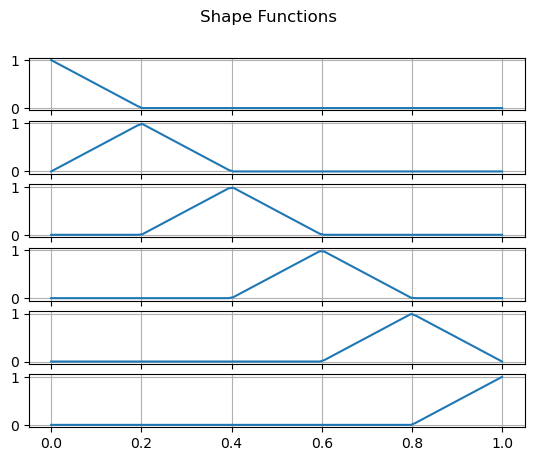

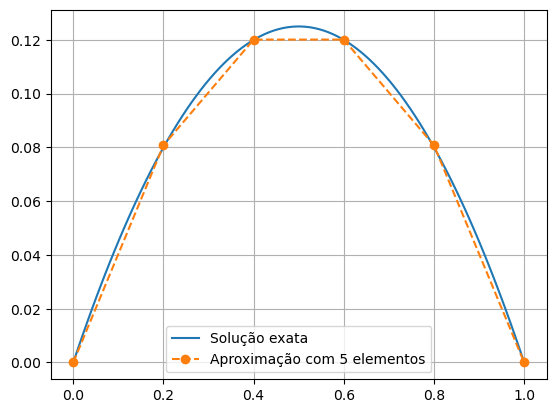

In [556]:
model = HiDeNN_for_FEM(dom, 6, equation, bound_conds)
model.plot_shape_functions()
model.plot_u_exact_vs_u_aprox(u_exact)
model

In [557]:
model.displacement_arr, model.K, model.nodes, len(model.u_aprox_arr)

(array([3.95959596e-66, 8.07745700e-02, 1.20116635e-01, 1.20116635e-01,
        8.07745700e-02, 3.95959596e-66]),
 array([[ 1.00000000e+65, -4.84134272e+00, -4.08121620e-02,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-4.84134272e+00,  9.74900520e+00, -4.84644424e+00,
         -6.12182430e-02,  0.00000000e+00,  0.00000000e+00],
        [-4.08121620e-02, -4.84644424e+00,  9.75410672e+00,
         -4.80563208e+00, -6.12182430e-02,  0.00000000e+00],
        [ 0.00000000e+00, -6.12182430e-02, -4.80563208e+00,
          9.75410672e+00, -4.84644424e+00, -4.08121620e-02],
        [ 0.00000000e+00,  0.00000000e+00, -6.12182430e-02,
         -4.84644424e+00,  9.74900520e+00, -4.84134272e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -4.08121620e-02, -4.84134272e+00,  1.00000000e+65]]),
 tensor([0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000], dtype=torch.float64,
        requires_grad=True),
 100)

In [558]:
model.u_aprox_arr

array([3.95959596e-66, 4.07952374e-03, 8.15904747e-03, 1.22385712e-02,
       1.63180949e-02, 2.03976187e-02, 2.44771424e-02, 2.85566662e-02,
       3.26361899e-02, 3.67157136e-02, 4.07952374e-02, 4.48747611e-02,
       4.89542848e-02, 5.30338086e-02, 5.71133323e-02, 6.11928561e-02,
       6.52723798e-02, 6.93519035e-02, 7.34314273e-02, 7.75109510e-02,
       8.11719646e-02, 8.31589376e-02, 8.51459106e-02, 8.71328836e-02,
       8.91198566e-02, 9.11068296e-02, 9.30938026e-02, 9.50807756e-02,
       9.70677486e-02, 9.90547216e-02, 1.01041695e-01, 1.03028668e-01,
       1.05015641e-01, 1.07002614e-01, 1.08989587e-01, 1.10976560e-01,
       1.12963533e-01, 1.14950506e-01, 1.16937479e-01, 1.18924452e-01,
       1.20116635e-01, 1.20116635e-01, 1.20116635e-01, 1.20116635e-01,
       1.20116635e-01, 1.20116635e-01, 1.20116635e-01, 1.20116635e-01,
       1.20116635e-01, 1.20116635e-01, 1.20116635e-01, 1.20116635e-01,
       1.20116635e-01, 1.20116635e-01, 1.20116635e-01, 1.20116635e-01,
      

In [559]:
model.forward()

array([3.95959596e-66, 4.07952374e-03, 8.15904747e-03, 1.22385712e-02,
       1.63180949e-02, 2.03976187e-02, 2.44771424e-02, 2.85566662e-02,
       3.26361899e-02, 3.67157136e-02, 4.07952374e-02, 4.48747611e-02,
       4.89542848e-02, 5.30338086e-02, 5.71133323e-02, 6.11928561e-02,
       6.52723798e-02, 6.93519035e-02, 7.34314273e-02, 7.75109510e-02,
       8.11719646e-02, 8.31589376e-02, 8.51459106e-02, 8.71328836e-02,
       8.91198566e-02, 9.11068296e-02, 9.30938026e-02, 9.50807756e-02,
       9.70677486e-02, 9.90547216e-02, 1.01041695e-01, 1.03028668e-01,
       1.05015641e-01, 1.07002614e-01, 1.08989587e-01, 1.10976560e-01,
       1.12963533e-01, 1.14950506e-01, 1.16937479e-01, 1.18924452e-01,
       1.20116635e-01, 1.20116635e-01, 1.20116635e-01, 1.20116635e-01,
       1.20116635e-01, 1.20116635e-01, 1.20116635e-01, 1.20116635e-01,
       1.20116635e-01, 1.20116635e-01, 1.20116635e-01, 1.20116635e-01,
       1.20116635e-01, 1.20116635e-01, 1.20116635e-01, 1.20116635e-01,
      

In [560]:
model.train()

tensor(9.6013, dtype=torch.float64, grad_fn=<MseLossBackward0>)

In [563]:
model.train(epochs=200, lr=0.5)

tensor(9.6013, dtype=torch.float64, grad_fn=<MseLossBackward0>)

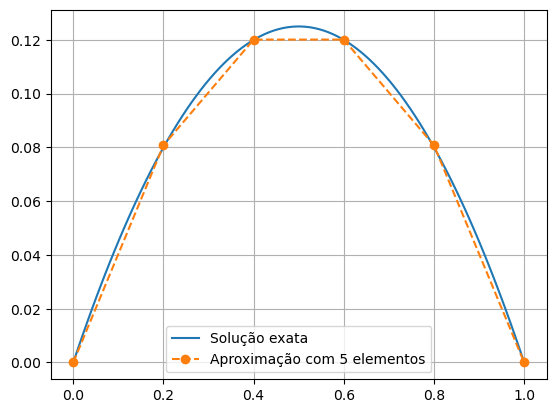

In [562]:
model.plot_u_exact_vs_u_aprox(u_exact)